*Title: Analysing Tropospheric Formaldehyde (HCHO) gas in Sri Lanka*

*Author: Benura Wickramanayake 💻*

*Date: 2024-03-25*

In [1]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DateType, DoubleType, StringType
from pyspark.sql.functions import isnan, sum as Fsum
from pyspark.sql import functions as F
import pyspark_dist_explore as pdx
from pyspark_dist_explore import hist
from pyspark.sql.functions import avg, when

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### PySpark Environment

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()

## Create Dataframe

Reference - https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html

In [3]:
# Define the schema
schema = StructType([
    StructField("HCHO_reading", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("Current_Date", DateType(), True),
    StructField("Next_Date", DateType(), True)
])

In [4]:
# load data
file_paths = [
    "Dataset\\col_mat_nuw_output.csv",
    "Dataset\\mon_kur_jaf_output.csv",
    "Dataset\\kan_output.csv"
]

In [5]:
# dataframe creation
df = spark.read.csv(file_paths, schema=schema, header=True)

Defined schema of the dataset with data types for each column, load 3 csv files (dataset) into DataFrame  

### Dataset Observations

In [6]:
# data types of columns in the DataFrame
data_types = df.dtypes

for col_name, col_type in data_types:
    print(f"'{col_name}' column data type - '{col_type}'")

'HCHO_reading' column data type - 'double'
'Location' column data type - 'string'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'


In [7]:
# df summary
df_summary = df.describe()
df_summary.show()

+-------+--------------------+-------------------+
|summary|        HCHO_reading|           Location|
+-------+--------------------+-------------------+
|  count|                7916|              12779|
|   mean|1.192609008729181...|               NULL|
| stddev|9.322891110805865E-5|               NULL|
|    min|-3.52473024357239...| Bibile, Monaragala|
|    max|8.997101837438971E-4|Nuwara Eliya Proper|
+-------+--------------------+-------------------+



In [8]:
# DF size
# rows
num_rows = df.count()
# columns
num_cols = len(df.columns)

print(f"Size of the DataFrame: ({num_rows}, {num_cols})")

Size of the DataFrame: (12779, 4)


In [9]:
# see first 50 rows
df.show(50, truncate=False)   #truncate - readability

+----------------------+------------------+------------+----------+
|HCHO_reading          |Location          |Current_Date|Next_Date |
+----------------------+------------------+------------+----------+
|1.919914652467399E-5  |Bibile, Monaragala|2019-01-02  |2019-01-03|
|2.8114479359302837E-5 |Bibile, Monaragala|2019-01-03  |2019-01-04|
|3.747998184385943E-5  |Bibile, Monaragala|2019-01-04  |2019-01-05|
|-1.7982608793453114E-5|Bibile, Monaragala|2019-01-05  |2019-01-06|
|1.4578368961799026E-4 |Bibile, Monaragala|2019-01-06  |2019-01-07|
|2.8285908025465342E-5 |Bibile, Monaragala|2019-01-07  |2019-01-08|
|NULL                  |Bibile, Monaragala|2019-01-08  |2019-01-09|
|1.4208501670509577E-4 |Bibile, Monaragala|2019-01-09  |2019-01-10|
|NULL                  |Bibile, Monaragala|2019-01-10  |2019-01-11|
|2.014587947072581E-5  |Bibile, Monaragala|2019-01-11  |2019-01-12|
|1.5827876632101837E-4 |Bibile, Monaragala|2019-01-12  |2019-01-13|
|NULL                  |Bibile, Monaragala|2019-

In [10]:
# unique values of location column
unique_locations = df.select("Location").distinct()
unique_locations.show()

+-------------------+
|           Location|
+-------------------+
|  Kurunegala Proper|
| Bibile, Monaragala|
|      Jaffna Proper|
|   Deniyaya, Matara|
|     Colombo Proper|
|Nuwara Eliya Proper|
|       Kandy Proper|
+-------------------+



# PreProcessing

## 1. Check NULL & NaN values

In [11]:
# Get # of null values for each locations
# Group by 'Location' and count null values in each group
null_counts = df.groupBy("Location").agg(
    F.sum(F.col("HCHO_reading").isNull().cast("int")).alias("Null_Count")
)

for row in null_counts.collect():
    location = row["Location"]
    null_count = row["Null_Count"]
    print(f"{location} - {null_count} null values")

Kurunegala Proper - 592 null values
Bibile, Monaragala - 694 null values
Jaffna Proper - 365 null values
Deniyaya, Matara - 847 null values
Colombo Proper - 487 null values
Nuwara Eliya Proper - 1085 null values
Kandy Proper - 793 null values


In [12]:
# sum of null value rows for each Location
null_counts.show()

+-------------------+----------+
|           Location|Null_Count|
+-------------------+----------+
|  Kurunegala Proper|       592|
| Bibile, Monaragala|       694|
|      Jaffna Proper|       365|
|   Deniyaya, Matara|       847|
|     Colombo Proper|       487|
|Nuwara Eliya Proper|      1085|
|       Kandy Proper|       793|
+-------------------+----------+



In [13]:
# total # of rows with null values in DF
total_null_rows = df.filter(df.HCHO_reading.isNull()).count()

print("Total number of rows with null values:", total_null_rows)

Total number of rows with null values: 4863


Full dataset has 12779 rows. 4863 rows have NULL values. We cant drop those rows bcz it has around 1/3 of full dataframe. So we should handle those values.

In [14]:
# check null values Column wise
for col in df.columns:
    null_count = df.filter(df[col].isNull()).count()
    print(f"Column: {col}, Null Count: {null_count}")

Column: HCHO_reading, Null Count: 4863


Column: Location, Null Count: 0
Column: Current_Date, Null Count: 0
Column: Next_Date, Null Count: 0


Also only 'HCHO_reading' column has NULL values

### Check NaN values 

In [15]:
# Check NaN values in non-numeric columns
non_numeric_cols = ["Location", "Current_Date", "Next_Date"]

for col in non_numeric_cols:
    nan_count = df.select(Fsum(F.col(col).isNull().cast("int"))).collect()[0][0]
    print(f"Number of NaN values in '{col}' column: {nan_count}")

# Count of NaN values in 'HCHO_reading' column
nan_count_hcho = df.select(Fsum(F.isnan(df["HCHO_reading"]).cast("int"))).collect()[0][0]
print(f"Number of NaN values in 'HCHO_reading' column: {nan_count_hcho}")

Number of NaN values in 'Location' column: 0
Number of NaN values in 'Current_Date' column: 0
Number of NaN values in 'Next_Date' column: 0
Number of NaN values in 'HCHO_reading' column: 0


So there are no any NaN values in the dataset.

We have to handle NULL values.

### Get unique values of each column

In [16]:
for col in df.columns:
    unique_values = df.select(col).distinct().collect()
    
    print(f"Column: {col}")
    for val in unique_values:
        print(val[0])
    print("---------------")

Column: HCHO_reading
9.694880280715724e-05
0.0002193736930364124
-6.385750734361702e-05
6.676890262375307e-05
0.00023581672172941003
0.0001330033250583554
0.00022376243823328678
0.00014415846380457713
4.471236742579997e-05
0.00025864763414889814
4.508168997927766e-05
0.00019078656381855803
0.0002282886546883753
0.00014234945934412017
0.00013770668199936483
0.00025294227253453225
0.0001091543470120435
6.048995265610632e-05
4.597268387000088e-05
8.415824387636693e-05
4.568596580117736e-05
0.0002163863036346548
5.4732213064223596e-05
6.928370223774921e-05
0.00013013847716940348
0.00018641590767590403
6.107487274713773e-05
0.00011186406323859304
0.00023167759544939152
0.00011737181324750144
0.00015482738489700523
0.00017165291269917717
5.044614104756958e-05
8.510380215899425e-05
0.0003417715575369086
0.00012375404956124178
0.00017683619048078177
9.049237826246958e-06
0.00011498307620892104
0.00031371571363920345
7.681634949705504e-05
0.00016171075016852758
6.794723518060958e-05
1.952057598

Some values are in Scientific notation.

## 2. Handle Scientific Notation 

Reference - https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.format_number.html , https://stackoverflow.com/questions/40206592/how-to-turn-off-scientific-notation-in-pyspark

In [17]:
# format HCHO_reading values with 10 decimal places
#df = df.withColumn("HCHO_reading_converted", F.format_number(F.col("HCHO_reading"), 15))

In [18]:
#df.show(10, truncate=False)

In [19]:
# data types of columns in the DataFrame
#data_types = df.dtypes

#for col_name, col_type in data_types:
    #print(f"'{col_name}' column data type - '{col_type}'")

In [20]:
# Cast the column to double data type
#df = df.withColumn("HCHO_reading_converted", df["HCHO_reading_converted"].cast("double"))

In [21]:
# data types of columns in the DataFrame
#data_types = df.dtypes

#for col_name, col_type in data_types:
    #print(f"'{col_name}' column data type - '{col_type}'")

In [22]:
# replace new column with "HCHO_reading" name
#df = df.drop("HCHO_reading").withColumnRenamed("HCHO_reading_converted", "HCHO_reading")

In [23]:
#df.show(10, truncate=False)

In [24]:
# data types of columns in the DataFrame
#data_types = df.dtypes

#for col_name, col_type in data_types:
    #print(f"'{col_name}' column data type - '{col_type}'")

## 2. Handle NULL values

Reference - https://pandas.pydata.org/docs/user_guide/missing_data.html , https://www.educba.com/pyspark-left-join/

### Decided to handle null values based on the Location. Fill NULL values with the mean HCHO reading for each location.

In [25]:
# calculate mean HCHO reading for each location
mean_hcho = df.groupBy("Location").agg(avg("HCHO_reading").alias("Mean_HCHO"))

mean_hcho.show(truncate=False)

+-------------------+---------------------+
|Location           |Mean_HCHO            |
+-------------------+---------------------+
|Kurunegala Proper  |1.340202702666862E-4 |
|Bibile, Monaragala |1.2643137974120453E-4|
|Jaffna Proper      |1.088086650369041E-4 |
|Deniyaya, Matara   |9.165608034246397E-5 |
|Colombo Proper     |1.5854269566699302E-4|
|Nuwara Eliya Proper|8.792586073767327E-5 |
|Kandy Proper       |1.0630856146355229E-4|
+-------------------+---------------------+



In [26]:
# join mean_hcho DataFrame with original DataFrame for filling null values
df = df.join(mean_hcho, "Location", "left").withColumn(
    "HCHO_reading",
    when(F.col("HCHO_reading").isNull(), mean_hcho["Mean_HCHO"]).otherwise(F.col("HCHO_reading"))
)

In [27]:
df.show()

+------------------+--------------------+------------+----------+--------------------+
|          Location|        HCHO_reading|Current_Date| Next_Date|           Mean_HCHO|
+------------------+--------------------+------------+----------+--------------------+
|Bibile, Monaragala|1.919914652467399E-5|  2019-01-02|2019-01-03|1.264313797412045...|
|Bibile, Monaragala|2.811447935930283...|  2019-01-03|2019-01-04|1.264313797412045...|
|Bibile, Monaragala|3.747998184385943E-5|  2019-01-04|2019-01-05|1.264313797412045...|
|Bibile, Monaragala|-1.79826087934531...|  2019-01-05|2019-01-06|1.264313797412045...|
|Bibile, Monaragala|1.457836896179902...|  2019-01-06|2019-01-07|1.264313797412045...|
|Bibile, Monaragala|2.828590802546534...|  2019-01-07|2019-01-08|1.264313797412045...|
|Bibile, Monaragala|1.264313797412045...|  2019-01-08|2019-01-09|1.264313797412045...|
|Bibile, Monaragala|1.420850167050957...|  2019-01-09|2019-01-10|1.264313797412045...|
|Bibile, Monaragala|1.264313797412045...|  

In [28]:
# data types of columns in the DataFrame
data_types = df.dtypes

for col_name, col_type in data_types:
    print(f"'{col_name}' column data type - '{col_type}'")

'Location' column data type - 'string'
'HCHO_reading' column data type - 'double'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'
'Mean_HCHO' column data type - 'double'


In [29]:
# Drop the "Mean_HCHO" column
df = df.drop("Mean_HCHO")

df.show()

+------------------+--------------------+------------+----------+
|          Location|        HCHO_reading|Current_Date| Next_Date|
+------------------+--------------------+------------+----------+
|Bibile, Monaragala|1.919914652467399E-5|  2019-01-02|2019-01-03|
|Bibile, Monaragala|2.811447935930283...|  2019-01-03|2019-01-04|
|Bibile, Monaragala|3.747998184385943E-5|  2019-01-04|2019-01-05|
|Bibile, Monaragala|-1.79826087934531...|  2019-01-05|2019-01-06|
|Bibile, Monaragala|1.457836896179902...|  2019-01-06|2019-01-07|
|Bibile, Monaragala|2.828590802546534...|  2019-01-07|2019-01-08|
|Bibile, Monaragala|1.264313797412045...|  2019-01-08|2019-01-09|
|Bibile, Monaragala|1.420850167050957...|  2019-01-09|2019-01-10|
|Bibile, Monaragala|1.264313797412045...|  2019-01-10|2019-01-11|
|Bibile, Monaragala|2.014587947072581E-5|  2019-01-11|2019-01-12|
|Bibile, Monaragala|1.582787663210183...|  2019-01-12|2019-01-13|
|Bibile, Monaragala|1.264313797412045...|  2019-01-13|2019-01-14|
|Bibile, M

In [30]:
# check null values Column wise
for col in df.columns:
    null_count = df.filter(df[col].isNull()).count()
    print(f"Column: {col}, Null Count: {null_count}")

Column: Location, Null Count: 0


Column: HCHO_reading, Null Count: 0
Column: Current_Date, Null Count: 0
Column: Next_Date, Null Count: 0


In [31]:
# check data types of columns in the DataFrame
data_types = df.dtypes

for col_name, col_type in data_types:
    print(f"'{col_name}' column data type - '{col_type}'")

'Location' column data type - 'string'
'HCHO_reading' column data type - 'double'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'


## 3. Save DataFrame

Reference - https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html,https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df, https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.shuffle.html  

### Convert PySpark DataFrame to Pandas DataFrame

In [32]:
# PySpark df to pandas df
pandas_df = df.toPandas()

# onvert data types in pandas df
pandas_df['Location'] = pandas_df['Location'].astype(str)
pandas_df['HCHO_reading'] = pandas_df['HCHO_reading'].astype(float)
pandas_df['Current_Date'] = pd.to_datetime(pandas_df['Current_Date'])
pandas_df['Next_Date'] = pd.to_datetime(pandas_df['Next_Date'])

# save pandas df 
csv_file_path = "DataFrame/pandas_df.csv"
pandas_df.to_csv(csv_file_path, index=False)

In [33]:
pandas_df.head(30)

,Location,HCHO_reading,Current_Date,Next_Date
0,"Bibile, Monaragala",0.000019,2019-01-02,2019-01-03
1,"Bibile, Monaragala",0.000028,2019-01-03,2019-01-04
2,"Bibile, Monaragala",0.000037,2019-01-04,2019-01-05
3,"Bibile, Monaragala",-0.000018,2019-01-05,2019-01-06
4,"Bibile, Monaragala",0.000146,2019-01-06,2019-01-07
5,"Bibile, Monaragala",0.000028,2019-01-07,2019-01-08
6,"Bibile, Monaragala",0.000126,2019-01-08,2019-01-09
7,"Bibile, Monaragala",0.000142,2019-01-09,2019-01-10
8,"Bibile, Monaragala",0.000126,2019-01-10,2019-01-11
9,"Bibile, Monaragala",0.000020,2019-01-11,2019-01-12


In [34]:
pandas_df.dtypes

Location                object
HCHO_reading           float64
Current_Date    datetime64[ns]
Next_Date       datetime64[ns]
dtype: object

## 5. Handle Duplicates

In [35]:
# count occurrences of each unique row
duplicate_counts = df.groupBy([col for col in df.columns]).count()

# rows with counts greater than 1
duplicate_counts = duplicate_counts.filter(F.col("count") > 1)

total_duplicates = duplicate_counts.count()

print(f"Total number of duplicate data points: {total_duplicates}")

Total number of duplicate data points: 0


So there are no any duplicate data points.

## 6. Handle Outliers

Reference - https://www.machinelearningplus.com/pyspark/pyspark-outlier-detection-and-treatment/

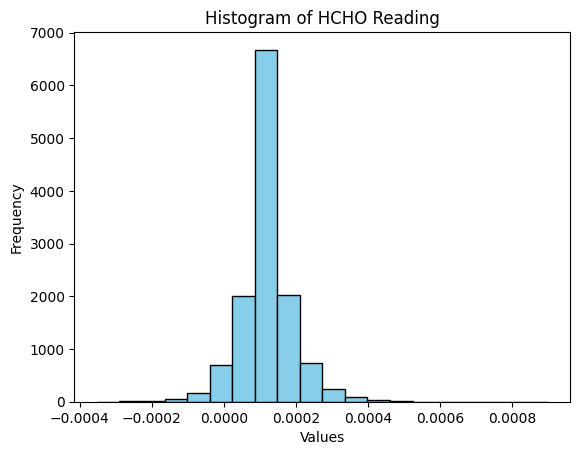

In [36]:
# extract values from the pandas DataFrame column
column_values = pandas_df['HCHO_reading']

plt.hist(column_values, bins=20, color='skyblue', edgecolor='black')

# labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of HCHO Reading')

# plot
plt.show()


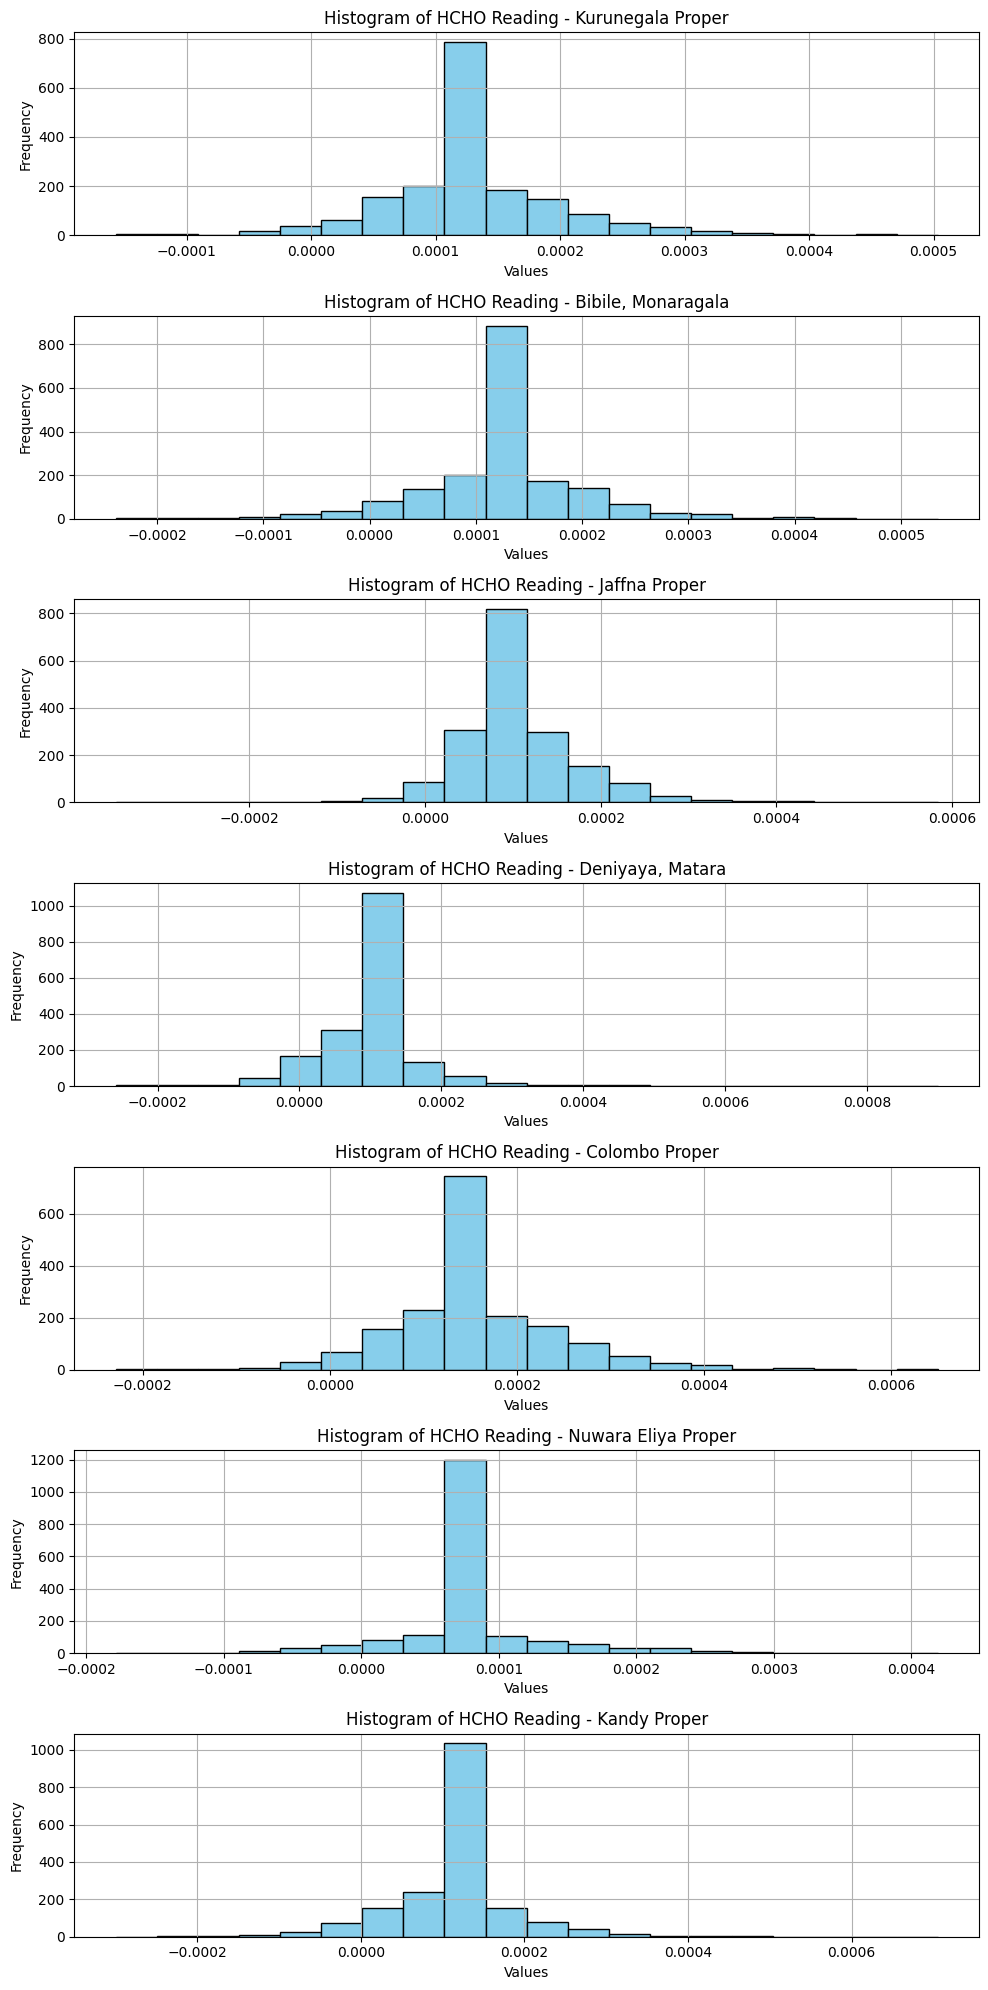

In [37]:
# List of locations for which you want to plot histograms
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

# Create subplots for each location
fig, axs = plt.subplots(len(locations), figsize=(10, 20))

# Plot histograms for each location
for i, location in enumerate(locations):
    # Filter DataFrame for the current location
    location_df = pandas_df[pandas_df['Location'] == location]
    
    # Extract values from the filtered DataFrame
    column_values = location_df['HCHO_reading']
    
    # Plot histogram for the current location
    axs[i].hist(column_values, bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Histogram of HCHO Reading - {location}')
    axs[i].set_xlabel('Values')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

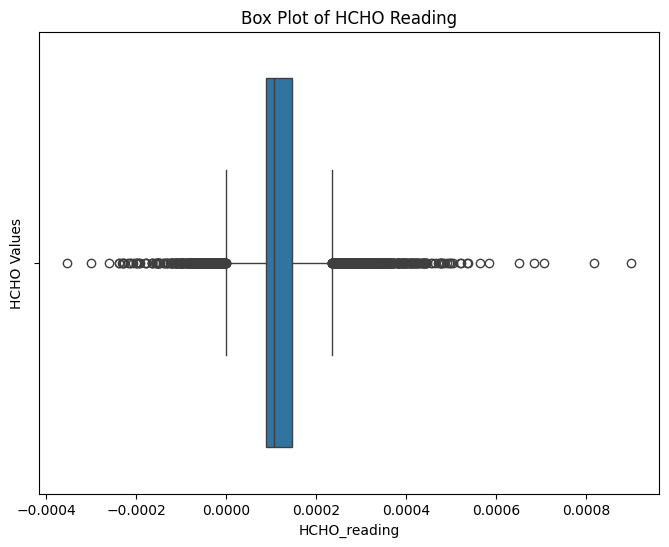

In [38]:
# Extract the values from the DataFrame column
column_values = pandas_df['HCHO_reading']

# Set up the figure and axes
plt.figure(figsize=(8, 6))

# Plot the box plot
sns.boxplot(x=column_values)

# Add labels and title
plt.ylabel('HCHO Values')
plt.title('Box Plot of HCHO Reading')

# Show the plot
plt.show()

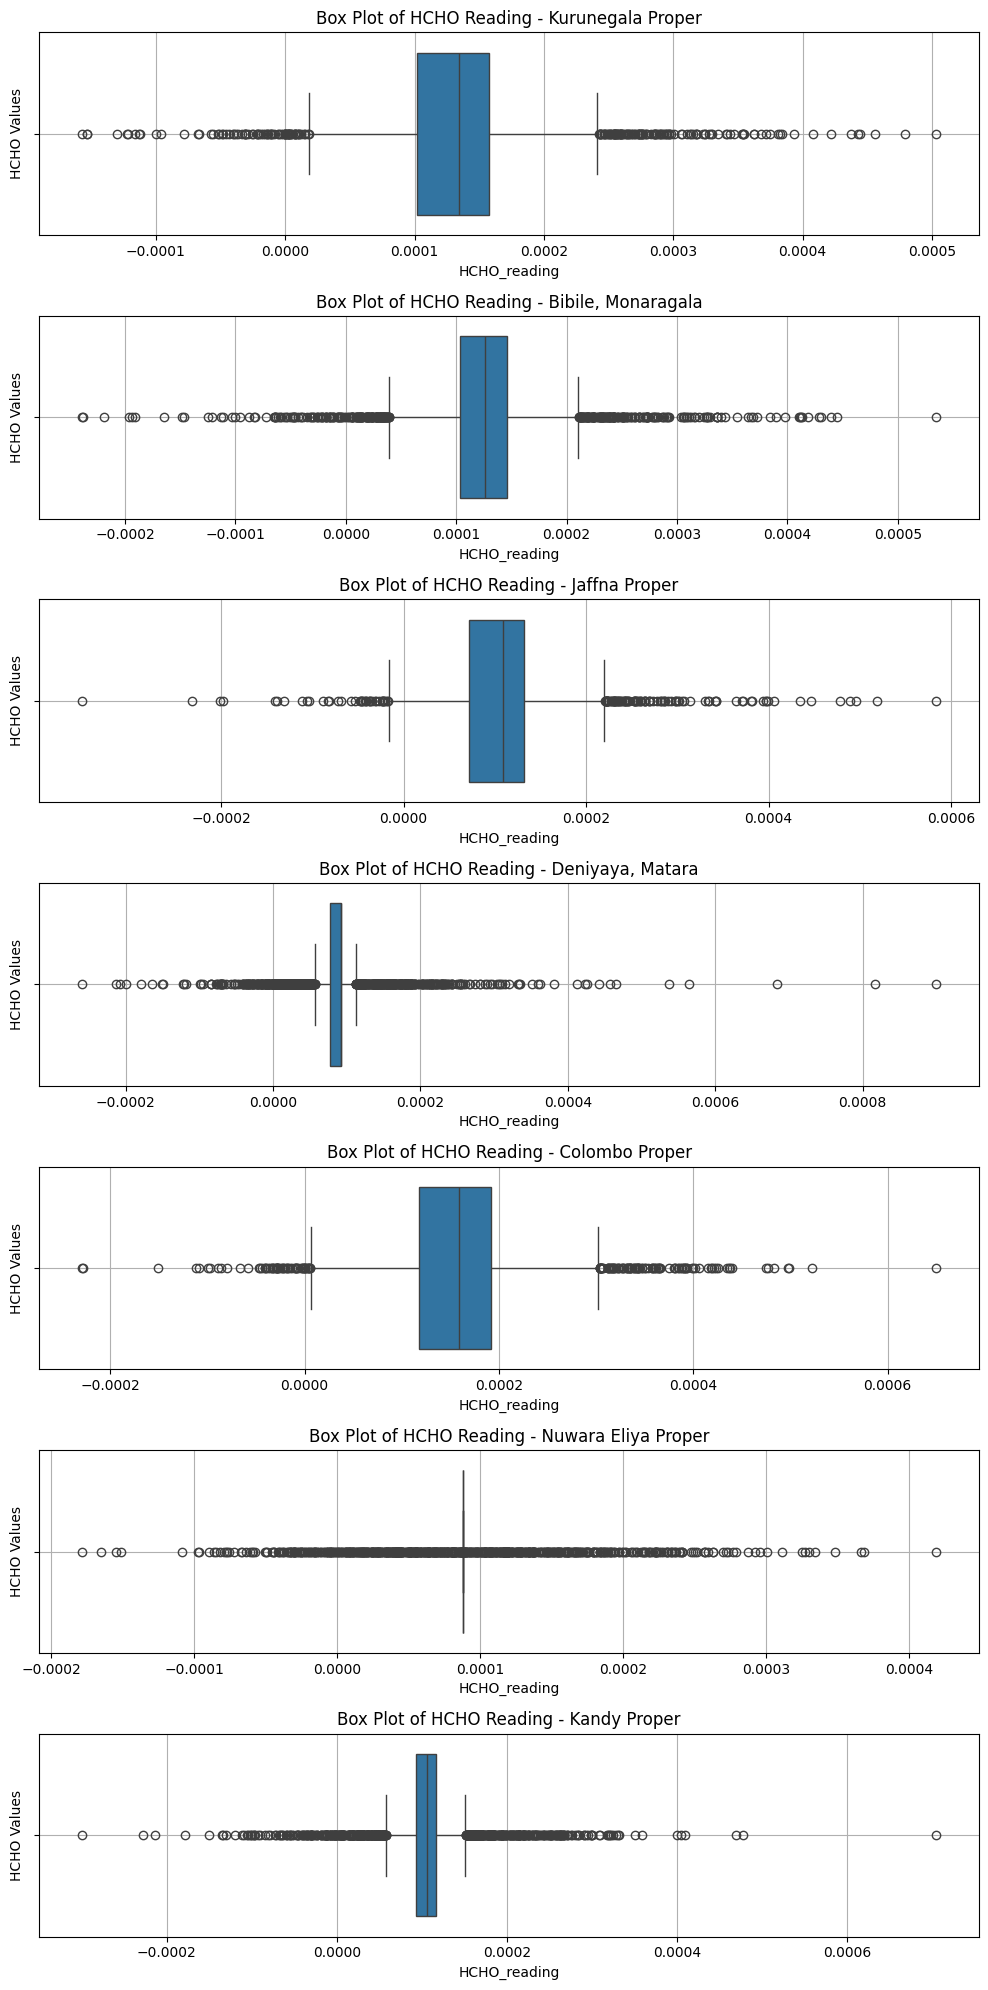

In [39]:
# List of locations for which you want to plot box plots
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

# Create subplots for each location
fig, axs = plt.subplots(len(locations), figsize=(10, 20))

# Plot box plots for each location
for i, location in enumerate(locations):
    # Filter DataFrame for the current location
    location_df = pandas_df[pandas_df['Location'] == location]
    
    # Extract values from the filtered DataFrame
    column_values = location_df['HCHO_reading']
    
    # box plot
    sns.boxplot(x=column_values, ax=axs[i])
    axs[i].set_title(f'Box Plot of HCHO Reading - {location}')
    axs[i].set_ylabel('HCHO Values')
    axs[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [40]:
# print df
print(pandas_df)

                 Location  HCHO_reading Current_Date  Next_Date
0      Bibile, Monaragala      0.000019   2019-01-02 2019-01-03
1      Bibile, Monaragala      0.000028   2019-01-03 2019-01-04
2      Bibile, Monaragala      0.000037   2019-01-04 2019-01-05
3      Bibile, Monaragala     -0.000018   2019-01-05 2019-01-06
4      Bibile, Monaragala      0.000146   2019-01-06 2019-01-07
...                   ...           ...          ...        ...
12774        Kandy Proper      0.000106   2023-12-27 2023-12-28
12775        Kandy Proper      0.000106   2023-12-28 2023-12-29
12776        Kandy Proper      0.000106   2023-12-29 2023-12-30
12777        Kandy Proper      0.000056   2023-12-30 2023-12-31
12778        Kandy Proper      0.000106   2023-12-31 2024-01-01

[12779 rows x 4 columns]


### Handle outliers of HCHO_reading column based on Location

In [41]:
# list of locations
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

In [42]:
# function to handle outliers using IQR method for each location
def handle_outliers_by_location(df, location):
    # get current location
    location_df = df[df['Location'] == location]
    
    # calculate Q1 and Q3 for HCHO_reading column
    Q1 = location_df['HCHO_reading'].quantile(0.25)
    Q3 = location_df['HCHO_reading'].quantile(0.75)
    
    # calculate IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # lower and upper bounds 
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Display lower and upper bounds
    print(f"Location: {location}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print("")
    
    # replace outlier values with the lower or upper bound
    location_df.loc[location_df['HCHO_reading'] < lower_bound, 'HCHO_reading'] = lower_bound
    location_df.loc[location_df['HCHO_reading'] > upper_bound, 'HCHO_reading'] = upper_bound
    
    return location_df

In [43]:
# use handle_outliers_by_location function for each location and concatenate the results
processed_dfs = [handle_outliers_by_location(pandas_df, location) for location in locations]
processed_df = pd.concat(processed_dfs)

print(processed_df)

Location: Kurunegala Proper
Lower Bound: 1.8108732471231384e-05
Upper Bound: 0.0002410697581195681

Location: Bibile, Monaragala
Lower Bound: 3.908743717217921e-05
Upper Bound: 0.0002108582742242753

Location: Jaffna Proper
Lower Bound: -1.6851102438871017e-05
Upper Bound: 0.00022072441651530643

Location: Deniyaya, Matara
Lower Bound: 5.668816636402683e-05
Upper Bound: 0.00011263682872952624

Location: Colombo Proper
Lower Bound: 6.026164171628087e-06
Upper Bound: 0.00030336112025578275

Location: Nuwara Eliya Proper
Lower Bound: 8.792586073767327e-05
Upper Bound: 8.792586073767327e-05

Location: Kandy Proper
Lower Bound: 5.788814391037094e-05
Upper Bound: 0.00015136536746884597

                Location  HCHO_reading Current_Date  Next_Date
1825   Kurunegala Proper      0.000088   2019-01-01 2019-01-02
1826   Kurunegala Proper      0.000137   2019-01-02 2019-01-03
1827   Kurunegala Proper      0.000148   2019-01-03 2019-01-04
1828   Kurunegala Proper      0.000018   2019-01-04 2019-0

### Check boxplot

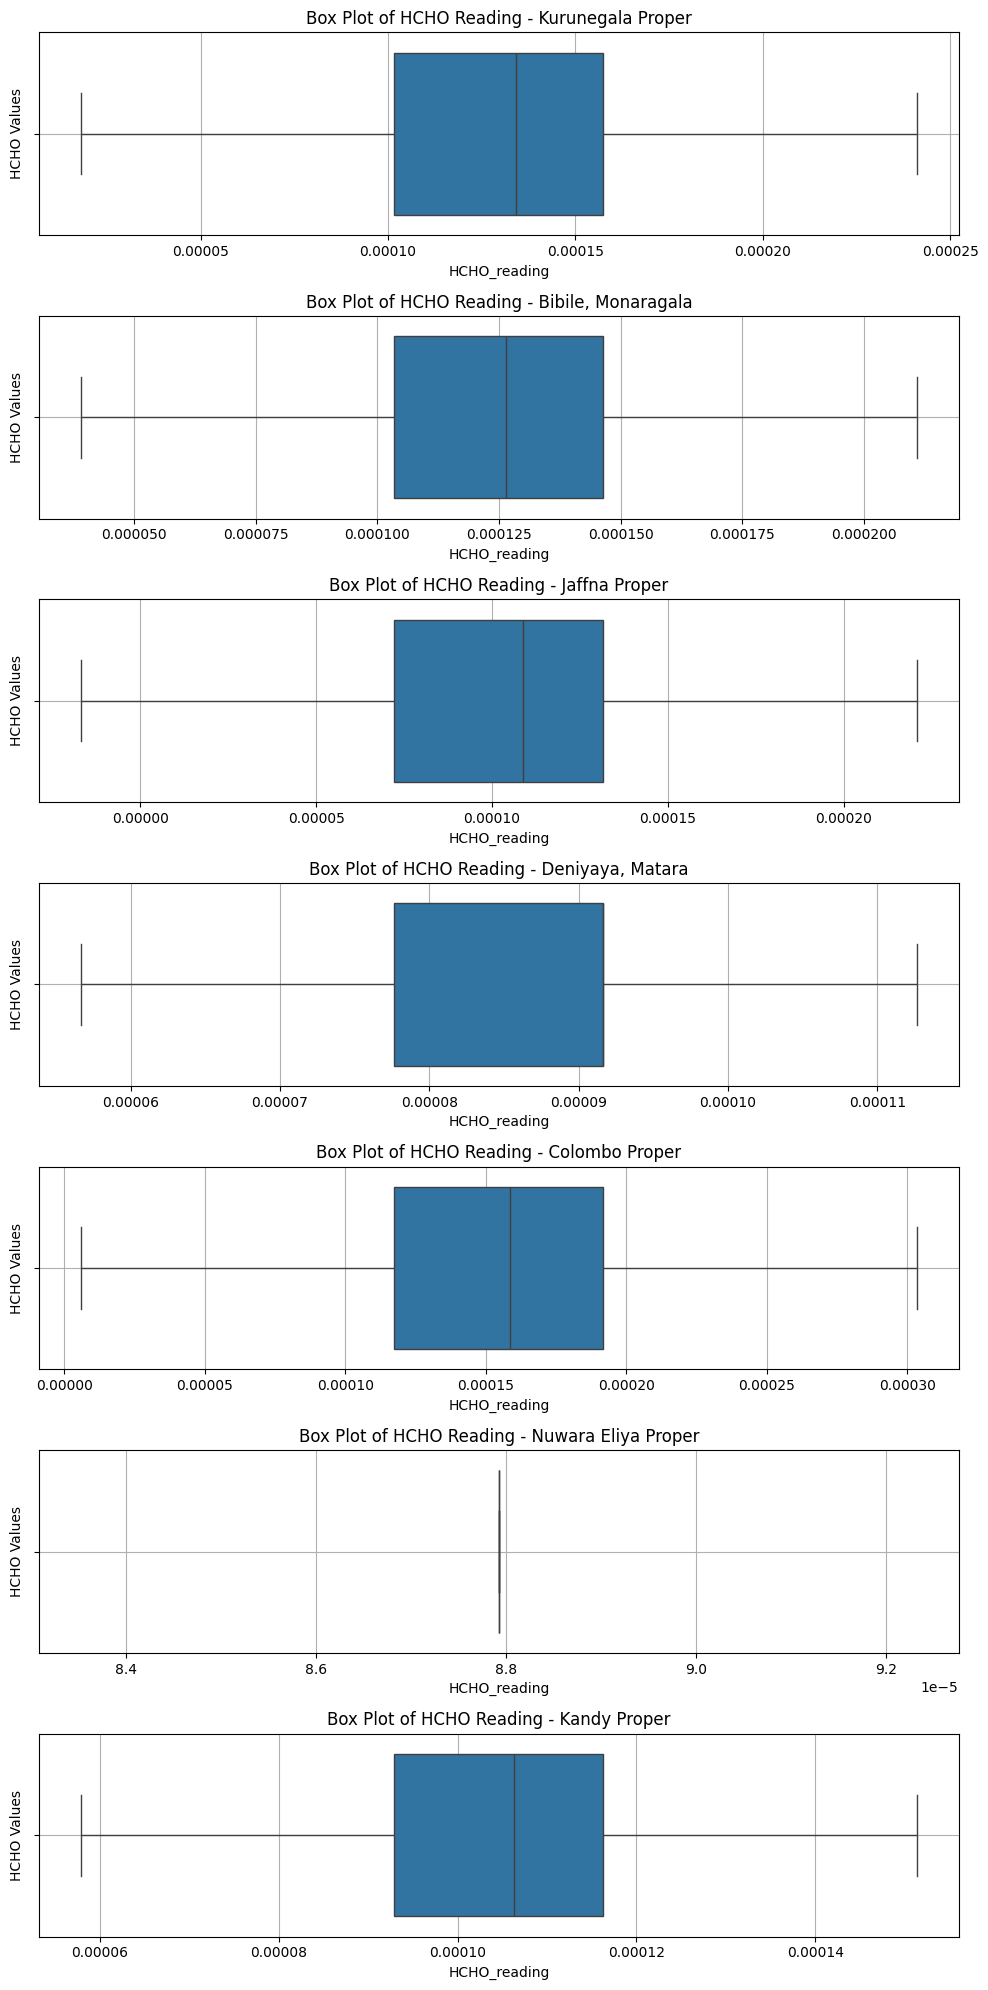

In [44]:
# List of locations for which you want to plot box plots
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

# Create subplots for each location
fig, axs = plt.subplots(len(locations), figsize=(10, 20))

# Plot box plots for each location
for i, location in enumerate(locations):
    # Filter DataFrame for the current location
    location_df = processed_df[processed_df['Location'] == location]
    
    # Extract values from the filtered DataFrame
    column_values = location_df['HCHO_reading']
    
    # box plot
    sns.boxplot(x=column_values, ax=axs[i])
    axs[i].set_title(f'Box Plot of HCHO Reading - {location}')
    axs[i].set_ylabel('HCHO Values')
    axs[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [45]:
processed_df.head(30)

,Location,HCHO_reading,Current_Date,Next_Date
1825,Kurunegala Proper,0.000088,2019-01-01,2019-01-02
1826,Kurunegala Proper,0.000137,2019-01-02,2019-01-03
1827,Kurunegala Proper,0.000148,2019-01-03,2019-01-04
1828,Kurunegala Proper,0.000018,2019-01-04,2019-01-05
1829,Kurunegala Proper,0.000241,2019-01-05,2019-01-06
1830,Kurunegala Proper,0.000102,2019-01-06,2019-01-07
1831,Kurunegala Proper,0.000192,2019-01-07,2019-01-08
1832,Kurunegala Proper,0.000122,2019-01-08,2019-01-09
1833,Kurunegala Proper,0.000097,2019-01-09,2019-01-10
1834,Kurunegala Proper,0.000113,2019-01-10,2019-01-11


## 7. Format inconsistencies

### Date columns

In [46]:
# convert Current_Date and Next_Date columns to datetime format
processed_df['Current_Date'] = pd.to_datetime(processed_df['Current_Date'])
processed_df['Next_Date'] = pd.to_datetime(processed_df['Next_Date'])

### Location column

In [47]:
# convert Location column to lowercase
processed_df['Location'] = processed_df['Location'].str.lower()

# remove leading and trailing whitespaces from Location column
processed_df['Location'] = processed_df['Location'].str.strip()

## 8. Exploring descriptive statistics 

In [48]:
# group by Location and calculate descriptive statistics
stats_by_location = processed_df.groupby('Location')['HCHO_reading'].agg(['mean', 'median', 'std'])

In [49]:
print("Descriptive Statistics for HCHO Levels (by Location):")
print(stats_by_location)

Descriptive Statistics for HCHO Levels (by Location):
                         mean    median       std
Location                                         
bibile, monaragala   0.000126  0.000126  0.000049
colombo proper       0.000157  0.000159  0.000073
deniyaya, matara     0.000088  0.000092  0.000019
jaffna proper        0.000106  0.000109  0.000055
kandy proper         0.000105  0.000106  0.000029
kurunegala proper    0.000132  0.000134  0.000056
nuwara eliya proper  0.000088  0.000088  0.000000


In [50]:
# overall statistics 
overall_stats = processed_df['HCHO_reading'].agg(['mean', 'median', 'std'])

In [51]:
print("Overall Descriptive Statistics for HCHO Levels:")
print(overall_stats)

Overall Descriptive Statistics for HCHO Levels:
mean      0.000115
median    0.000106
std       0.000052
Name: HCHO_reading, dtype: float64


C:\Users\benur\AppData\Local\Temp\ipykernel_20284\2775920275.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=processed_df, x='Location', y='HCHO_reading', ax=axs[1, 1], palette='Set2')
C:\Users\benur\AppData\Local\Temp\ipykernel_20284\2775920275.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')


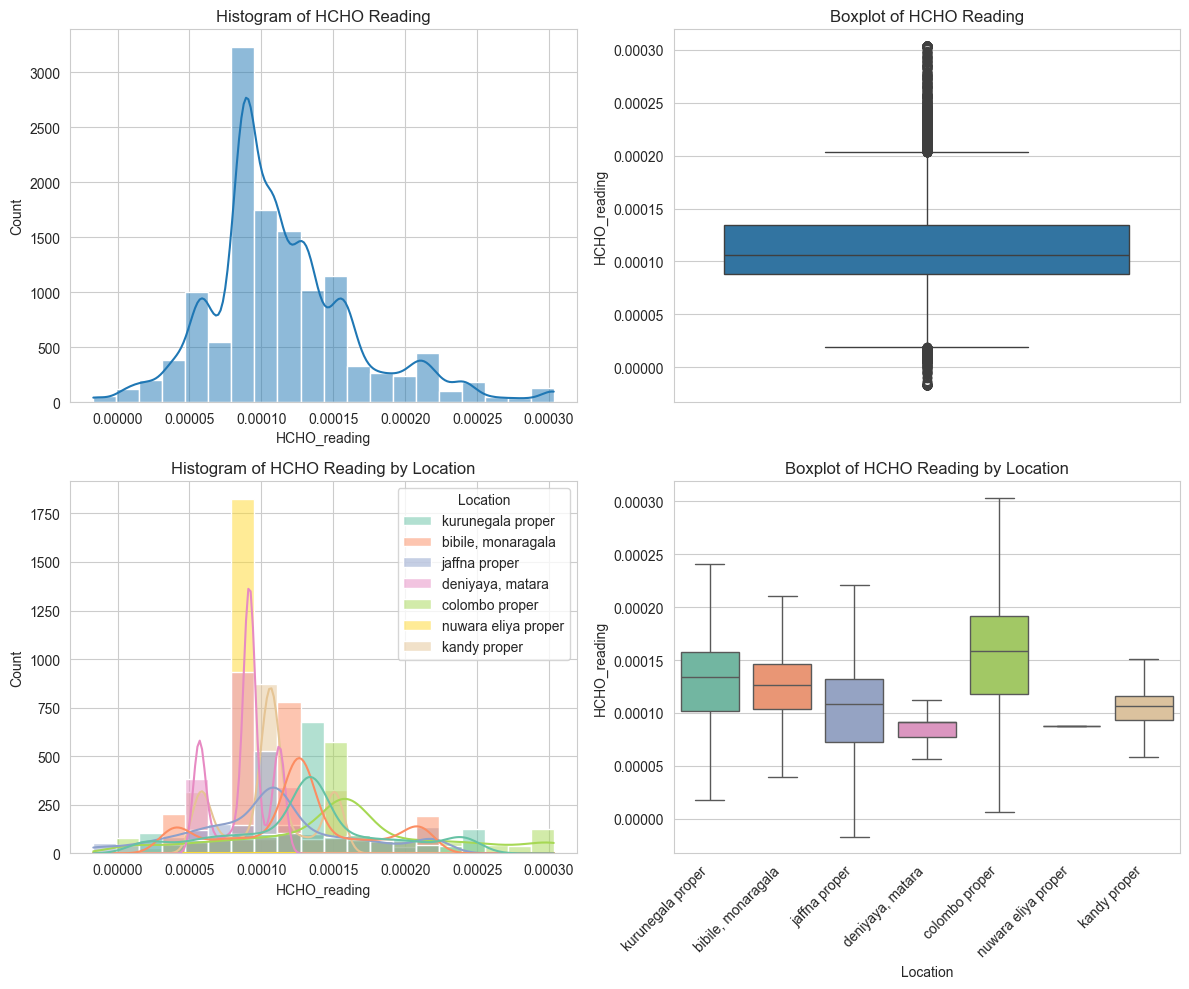

In [52]:
# Set the style of seaborn plots
sns.set_style('whitegrid')

# Create a figure with subplots for histograms and boxplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms for HCHO levels
sns.histplot(data=processed_df, x='HCHO_reading', ax=axs[0, 0], bins=20, kde=True)
axs[0, 0].set_title('Histogram of HCHO Reading')

# Plot boxplot for HCHO levels
sns.boxplot(data=processed_df, y='HCHO_reading', ax=axs[0, 1])
axs[0, 1].set_title('Boxplot of HCHO Reading')

# Plot histograms for HCHO levels by Location
sns.histplot(data=processed_df, x='HCHO_reading', hue='Location', ax=axs[1, 0], bins=20, kde=True, palette='Set2')
axs[1, 0].set_title('Histogram of HCHO Reading by Location')

# Plot boxplot for HCHO levels by Location
sns.boxplot(data=processed_df, x='Location', y='HCHO_reading', ax=axs[1, 1], palette='Set2')
axs[1, 1].set_title('Boxplot of HCHO Reading by Location')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()